# Transfer learning-based image classification

Motivation: In some application domains, we cannot get a large amount of data, which makes it difficult or even impossible to train the deep learning models from scratch. One common approach to address this problem is transfer learning. Researchers attempt to address this problem with transfer learning. * Understand what is transfer learning, and why transfer learning can help to address this problem.
Goal: Improve the performance in remote sensing application with small dataset via transfer learning.


1. Complete the project and submit the code. For the code, you can get help from github. (20 points)
    a) Students should try their best to improve the classification performance on EuroSAT by using some strategies like data augmentation. (You can follow these steps to complete the project)
    - i) Download and read the miniImageNet (Because the dataset miniImageNet usually is used in the few-shot learning task. Hence, the train, val, and test data are from different categories. For easier, you can only focus on the train.tar, and split the data in train.tar as train, val, and test dataset, which means you can ignore both val.tar and test.tar.) & EuroSAT(RGB) datasets. (2 points)
    - ii) Pretrain a model (ResNet10, also can be ResNet18, VGG, Vision Transformer, etc.) on the training set of miniImageNet, evaluate & test it on the validation & test set. (7 points)
    - iii) Save the pretrained model. (1 point)
    - iv) Choose 100 images from EuroSAT dataset, which are from 5 different categories and each category includes 20 samples. You should randomly choose 25 images from these 100 samples as training set (The 25 images should be from the 5 different categories. Each category includes 5 images). (3 points)
    - v) Fine-tune the pretrained model with these 25 training images and test it on the rest 75 samples, show the results. Better to fine-tuning several times on different 100 EuroSAT images and get their average result. (7 points)

     b) Compare the performance of different models (ResNet18, VGG, Vision Transformer, etc.), and investigate the different optimization strategies. (This part will be used as a bonus item, 2 points)

     c) If it’s possible, you can evaluate on the other datasets such as CropDiseases, CUB, ISIC, ChestX, etc. (This part will be used as a bonus item, 2 points)

     d) Experiments: python=3.9.18, torch=2.1.1, torchvision=0.16.1

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xvf "/content/drive/MyDrive/Deep learning/Project/train.tar" -C "/content/drive/MyDrive/Deep learning/Project/kk"

## i - Download and read the miniImageNet & EuroSAT(RGB) datasets. (2 points)

In [4]:
import os
from os.path import join, isfile, isdir
import tarfile
import zipfile
import shutil
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets, models
import numpy as np
import random

path = '/content/drive/MyDrive/Deep learning/Project/kk'

In [5]:
miniImageNet = os.path.join(path, 'train')

for item in os.listdir(miniImageNet):
    print(item)

n01532829
n01558993
n01704323
n01749939
n01770081
n01843383
n01910747
n02074367
n02089867
n02091831
n02101006
n02105505
n02108089
n02108551
n02111277
n02113712
n02120079
n02165456
n02457408
n02606052
n02687172
n02747177
n02795169
n02823428
n02966193
n03017168
n03047690
n03062245
n03207743
n03220513
n03337140
n03347037
n03400231
n03476684
n03527444
n03676483
n03838899
n03854065
n03888605
n03908618
n03924679
n03998194
n04067472
n04243546
n04251144
n04258138
n04275548
n04296562
n04389033
n04435653
n04443257
n04509417
n04515003
n04596742
n04604644
n04612504
n06794110
n07584110
n07697537
n07747607
n09246464
n13054560
n13133613
n02108915


## ii - Pretrain a model (ResNet18) on the training set of miniImageNet, evaluate & test it on the validation & test set. (7 points)

In [6]:
def listdir(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

In [7]:
class_names=sorted(listdir(miniImageNet))
print(class_names)
print(len(class_names))

['n01532829', 'n01558993', 'n01704323', 'n01749939', 'n01770081', 'n01843383', 'n01910747', 'n02074367', 'n02089867', 'n02091831', 'n02101006', 'n02105505', 'n02108089', 'n02108551', 'n02108915', 'n02111277', 'n02113712', 'n02120079', 'n02165456', 'n02457408', 'n02606052', 'n02687172', 'n02747177', 'n02795169', 'n02823428', 'n02966193', 'n03017168', 'n03047690', 'n03062245', 'n03207743', 'n03220513', 'n03337140', 'n03347037', 'n03400231', 'n03476684', 'n03527444', 'n03676483', 'n03838899', 'n03854065', 'n03888605', 'n03908618', 'n03924679', 'n03998194', 'n04067472', 'n04243546', 'n04251144', 'n04258138', 'n04275548', 'n04296562', 'n04389033', 'n04435653', 'n04443257', 'n04509417', 'n04515003', 'n04596742', 'n04604644', 'n04612504', 'n06794110', 'n07584110', 'n07697537', 'n07747607', 'n09246464', 'n13054560', 'n13133613']
64


In [8]:
classes = listdir(miniImageNet)
print(classes)

<generator object listdir at 0x79dc6c94a6c0>


In [9]:
split_dataset_path = os.path.join(path, 'split_dataset')
os.makedirs(split_dataset_path, exist_ok=True)

classes = [class_name for class_name in listdir(miniImageNet) if isdir(join(miniImageNet, class_name))]

train_path = os.path.join(split_dataset_path, 'train')
val_path = os.path.join(split_dataset_path, 'val')
test_path = os.path.join(split_dataset_path, 'test')
os.makedirs(train_path, exist_ok=True)
os.makedirs(val_path, exist_ok=True)

os.makedirs(test_path, exist_ok=True)

for class_name in classes:
    class_folder = os.path.join(miniImageNet, class_name)
    images = [img for img in listdir(class_folder) if isfile(join(class_folder, img))]

    train_images, test_val_images = train_test_split(images, test_size=0.3, random_state=42)
    val_images, test_images = train_test_split(test_val_images, test_size=0.5, random_state=42)

    for img in train_images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(train_path, img))

    for img in val_images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(val_path, img))

    for img in test_images:
        shutil.copy(os.path.join(class_folder, img), os.path.join(test_path, img))

print("Dataset split into train, validation, and test sets.")

Dataset split into train, validation, and test sets.


In [10]:
print('len',len(train_images),len(val_images),len(test_images))

len 420 90 90


In [11]:
input_shape = (224, 224, 3)
num_classes = len(class_names)

In [10]:
def organize_files(source_path, destination_path):
    for file_name in os.listdir(source_path):
        source_file_path = os.path.join(source_path, file_name)

        if os.path.isfile(source_file_path):
            prefix = file_name[:9]
            destination_folder = os.path.join(destination_path, prefix)

            if not os.path.exists(destination_folder):
                os.makedirs(destination_folder)

            destination_file_path = os.path.join(destination_folder, file_name)
            shutil.move(source_file_path, destination_file_path)

# Organize files in the test path
organize_files(test_path, test_path)

# Organize files in the train path
organize_files(train_path, train_path)

# Organize files in the validation path
organize_files(val_path, val_path)

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [13]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [14]:
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=transform)
test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [16]:
def train_model(model, lr, weight_decay, optimizer_name):
    model = model
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(optimizer_name, model, lr, weight_decay)

    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
        model.eval()

    correct_val, total_val = 0, 0
    with torch.no_grad():
        for inputs_val, labels_val in val_loader:
            inputs_val, labels_val = inputs_val.to(device), labels_val.to(device)

            outputs_val = model(inputs_val)
            _, predicted_val = torch.max(outputs_val, 1)
            total_val += labels_val.size(0)
            correct_val += (predicted_val == labels_val).sum().item()

    accuracy_val = correct_val / total_val
    print(f"Validation Accuracy: {accuracy_val * 100:.2f}%")

    return accuracy_val

In [17]:
def get_optimizer(optimizer_name, model, lr, weight_decay):
    if optimizer_name == 'Adam':
        return optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    elif optimizer_name == 'SGD':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

In [17]:
# Hyperparameter search space
learning_rates = [0.001, 0.01, 0.1]
weight_decays = [0.0001, 0.001, 0.01]
optimizer_names = ['Adam', 'SGD']

best_accuracy = 0.0
best_hyperparameters = {}

In [ ]:
for lr in learning_rates:
    for weight_decay in weight_decays:
            for optimizer_name in optimizer_names:
                print(f"\nTesting: LR={lr}, Weight Decay={weight_decay}, Optimizer={optimizer_name}")
                model = models.resnet18(pretrained=False, num_classes=64)
                accuracy_val = train_model(model, lr, weight_decay, optimizer_name)
                if accuracy_val > best_accuracy:
                    best_accuracy = accuracy_val
                    best_hyperparameters = {
                        'lr': lr,
                        'weight_decay': weight_decay,
                        'optimizer': optimizer_name
                    }
print("\nBest Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")


Testing: LR=0.001, Weight Decay=0.0001, Optimizer=Adam
Epoch 1/10, Loss: 3.6993000515869685
Epoch 2/10, Loss: 3.246103687797274
Epoch 3/10, Loss: 2.8740434618223283
Epoch 4/10, Loss: 2.5633426704577036
Epoch 5/10, Loss: 2.320163983816192
Epoch 6/10, Loss: 2.1133046861205784
Epoch 7/10, Loss: 1.9269246480294637
Epoch 8/10, Loss: 1.7532025697685423
Epoch 9/10, Loss: 1.5901795744186356
Epoch 10/10, Loss: 1.4196280646182242
Validation Accuracy: 48.65%

Testing: LR=0.001, Weight Decay=0.0001, Optimizer=SGD
Epoch 1/10, Loss: 3.7280751262392315
Epoch 2/10, Loss: 3.285332181340172
Epoch 3/10, Loss: 2.99910523550851
Epoch 4/10, Loss: 2.7664275402114504
Epoch 5/10, Loss: 2.571509135337103
Epoch 6/10, Loss: 2.3996174082869577
Epoch 7/10, Loss: 2.2522600386823926
Epoch 8/10, Loss: 2.1204336694308688
Epoch 9/10, Loss: 1.9828642254783995
Epoch 10/10, Loss: 1.8517515947421392
Validation Accuracy: 43.40%

Testing: LR=0.001, Weight Decay=0.001, Optimizer=Adam
Epoch 1/10, Loss: 3.7291118235815137
Epoch

In [ ]:
# Test the model on the test set
model.eval()
correct_test, total_test = 0, 0

with torch.no_grad():
    for inputs_test, labels_test in test_loader:
        inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

        outputs_test = model(inputs_test)
        _, predicted_test = torch.max(outputs_test, 1)
        total_test += labels_test.size(0)
        correct_test += (predicted_test == labels_test).sum().item()

accuracy_test = correct_test / total_test
print(f"Test Accuracy: {accuracy_test * 100:.2f}%")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Accuracy: 41.27%


 ## iii - Save the pretrained model. (1 point)

In [ ]:
# Save the pretrained model
torch.save(model.state_dict(), '/content/drive/MyDrive/Deep learning/Project/pretrained_resnet18.pth')

print("Pretrained model saved.")

Pretrained model saved.


## iv - Choose 100 images from EuroSAT dataset, which are from 5 different categories and each category includes 20 samples. You should randomly choose 25 images from these 100 samples as training set (The 25 images should be from the 5 different categories. Each category includes 5 images). (3 points)

In [ ]:
!unzip "/content/drive/MyDrive/Deep learning/Project/EuroSAT.zip" -d "/content/drive/MyDrive/Deep learning/Project"

In [ ]:
EuroSAT = os.path.join(path, 'EuroSAT (RGB)')
EuroSAT = "/content/drive/MyDrive/Deep learning/Project/2750"
for item in os.listdir(EuroSAT):
    print(item)

SeaLake
Pasture
PermanentCrop
Residential
Industrial
HerbaceousVegetation
Highway
Forest
River
AnnualCrop


In [ ]:
def select_images(dataset_path, num_categories=5, num_samples_per_category=20, num_training_images_per_category=5):
    categories = random.sample(list(os.listdir(dataset_path)), num_categories)
    training_images = []
    testing_images = []

    for category in categories:
        category_path = os.path.join(dataset_path, category)
        images_in_category = list(os.listdir(category_path))
        selected_images = random.sample(images_in_category, num_samples_per_category)

        training_images.extend(selected_images[:num_training_images_per_category])
        testing_images.extend(selected_images[num_training_images_per_category:])

    return training_images, testing_images, categories

dataset_path = EuroSAT
training_set, testing_set, names_classes = select_images(dataset_path)

## v - Fine tuning


Creating the necesary dataset and dataloader classes

In [ ]:
from PIL import Image
from torch.utils.data import Dataset

class EuroSATdataset(Dataset):
    def __init__(self, file_names, class_names, root_dir = "/content/drive/MyDrive/Deep learning/Project/2750", transform=None):
        self.root_dir = root_dir
        self.file_names = file_names
        self.class_names = class_names
        self.transform = transform
        self.file_paths, self.labels = self._build_file_paths_and_labels()

    def _build_file_paths_and_labels(self):
        file_paths = []
        labels = []
        for file_name in self.file_names:
          class_name = file_name.split("_")[0]
          file_paths.append(os.path.join(self.root_dir,class_name,file_name))
          labels.append(self.class_names.index(class_name))
        return file_paths, labels

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        image = Image.open(img_path)

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]

        return image, label

train_dataset = EuroSATdataset(training_set,names_classes, transform = transform)
test_dataset = EuroSATdataset(testing_set,names_classes, transform = transform)

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
test_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)

Donwload the previously trained model and freeze all the convolutional layers except the last one. And prepare the model for our task

In [ ]:
def get_model_to_finetune():
  model = models.resnet18(pretrained=False)
  model.fc = nn.Linear(model.fc.in_features, 64)
  model.load_state_dict(torch.load("/content/drive/MyDrive/Deep learning/Project/pretrained_resnet18_2.pth"))
  for p in model.parameters():
    p.requires_grad = False
  for p in model.layer4[1].parameters():
    p.requires_grad = True

  model.fc = nn.Sequential(
      nn.Linear(model.fc.in_features, 5),
      nn.Softmax(dim=1)  # Add softmax layer for classification
  )
  return model


In [ ]:
def finetune_model(model, lr,weight_decay, train_dataloader, n_epochs):
    model = model

    model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)

    # Training the model
    num_epochs = n_epochs
    train_accs = []
    test_accs = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            #To get the accuracy
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = correct / total
        test_accuracy = test_model(model,test_dataloader)
        #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_dataloader)}, Train_acc: {accuracy * 100:.2f}, Test_acc: {test_accuracy * 100:.2f}")
        test_accs.append(test_model(model,test_dataloader))
        train_accs.append(accuracy)

    return accuracy, train_accs,test_accs

In [ ]:
def test_model(model,test_dataloader):

  model.eval()
  correct_test, total_test = 0, 0

  with torch.no_grad():
      for inputs_test, labels_test in test_dataloader:
          inputs_test, labels_test = inputs_test.to(device), labels_test.to(device)

          outputs_test = model(inputs_test)
          _, predicted_test = torch.max(outputs_test, 1)
          total_test += labels_test.size(0)
          correct_test += (predicted_test == labels_test).sum().item()

  accuracy_test = correct_test / total_test
  return accuracy_test

Experimental setup for the batch size

Batch size: 1
Batch size: 4
Batch size: 7
Batch size: 10
Batch size: 13
Batch size: 16
Batch size: 19
Batch size: 22


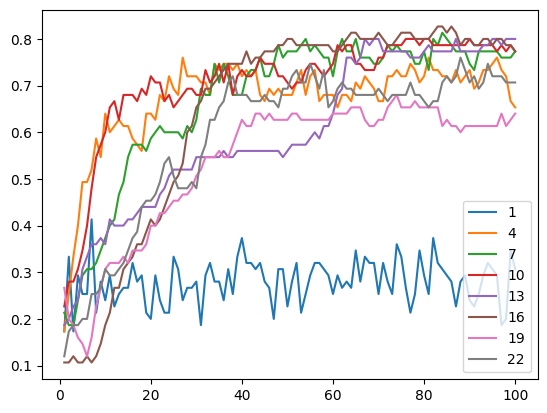

In [ ]:
import matplotlib.pyplot as plt
model = get_model_to_finetune()
training_set, testing_set, names_classes = select_images(dataset_path)

#Create the dataset/dataloader objects
train_dataset = EuroSATdataset(training_set,names_classes, transform = transform)
test_dataset = EuroSATdataset(testing_set,names_classes, transform = transform)

for i in range(1,25,3):
  print("Batch size:", i)
  model = get_model_to_finetune()
  train_dataloader = DataLoader(train_dataset, batch_size=i, shuffle=True, num_workers=2)
  test_dataloader = DataLoader(test_dataset, batch_size=i, shuffle=True, num_workers=2)
  _, train_accs,test_accs = finetune_model(model,0.0005,0.002, train_dataloader,100)
  test_model(model,test_dataloader)
  epochs = range(1, len(train_accs) + 1)
  plt.plot(epochs, test_accs, label=f"{i}")
plt.legend()

The final loop, we fine tune the model several times with randomly selected data, to then get the average.

Training the 0 th time...
Final test accuracy:  0.68
Training the 1 th time...
Final test accuracy:  0.68
Training the 2 th time...
Final test accuracy:  0.7333333333333333
Training the 3 th time...
Final test accuracy:  0.6933333333333334
Training the 4 th time...
Final test accuracy:  0.8533333333333334
Training the 5 th time...
Final test accuracy:  0.6533333333333333
Training the 6 th time...
Final test accuracy:  0.7466666666666667
Training the 7 th time...
Final test accuracy:  0.68
Training the 8 th time...
Final test accuracy:  0.6933333333333334
Training the 9 th time...
Final test accuracy:  0.6933333333333334
---------------------- 

After fine tuning the model 10 times, it obtained an average test accuracy of: 0.7106666666666668


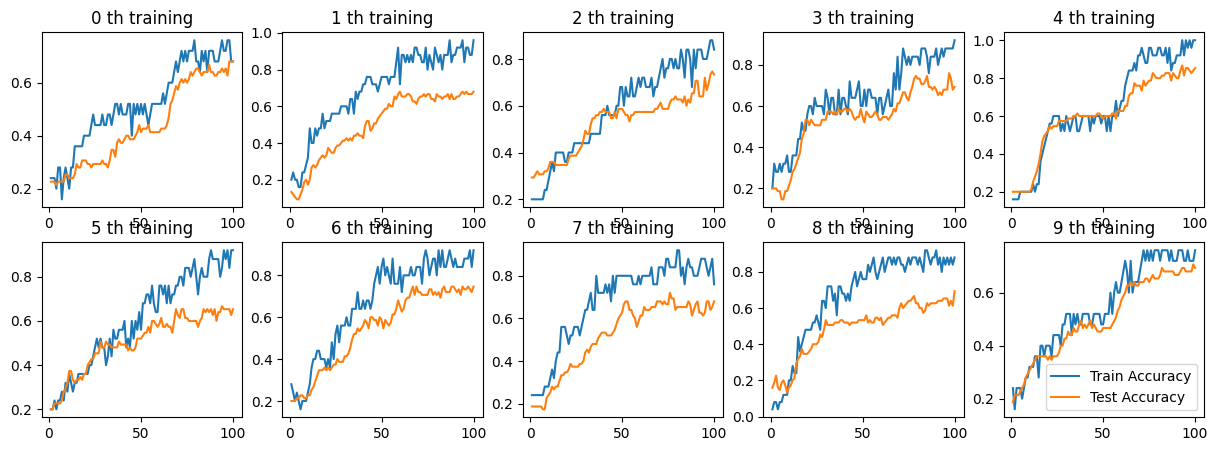

In [ ]:
n_times = 10

lr = 0.0005
weight_decay = 0.002
batch_size = 13
n_epochs = 100

train_accuracies = np.zeros(n_times)
test_accuracies = np.zeros(n_times)
plt.figure(figsize=(15,5))

for i in range(n_times):
  print(f"Training the {i} th time...")
  #Select the 100 images from 5 random classes
  dataset_path = EuroSAT
  training_set, testing_set, names_classes = select_images(dataset_path)

  #Create the dataset/dataloader objects
  train_dataset = EuroSATdataset(training_set,names_classes, transform = transform)
  test_dataset = EuroSATdataset(testing_set,names_classes, transform = transform)
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

  #Get the model
  model = get_model_to_finetune()

  #Train and test the model
  train_acc, train_accs ,test_accs = finetune_model(model, lr, weight_decay,train_dataloader, n_epochs)
  test_acc = test_model(model, test_dataloader)

  #Plot the training procces:
  epochs = range(1, len(train_accs) + 1)
  plt.subplot(2, 5, i+1)
  plt.plot(epochs, train_accs, label='Train Accuracy')
  plt.plot(epochs, test_accs, label='Test Accuracy')
  if i == 9:
    plt.legend()
  plt.title(f"{i} th training")
  print("Final test accuracy: ", test_acc)

  #Store the accuracies
  test_accuracies[i] = test_acc
  train_accuracies[i] = train_acc


print("---------------------- \n")
print(f"After fine tuning the model {n_times} times, it obtained an average test accuracy of: {np.mean(test_accuracies)}")



## b) Compare the performance of different models (Vision Transformer, etc.) (2 points)

In [ ]:
learning_rates = [0.001, 0.01]
weight_decays = [0.0001, 0.001]
optimizer_names = ['Adam', 'SGD']

best_accuracy = 0.0
best_hyperparameters={}

num_classes=len(train_dataset.classes)

for lr in learning_rates:
    for weight_decay in weight_decays:
            for optimizer_name in optimizer_names:
                print(f"\nTesting: LR={lr}, Weight Decay={weight_decay}, Optimizer={optimizer_name}")

                model = models.vit_b_32(num_classes=64)
                accuracy_val = train_model(model, lr, weight_decay, optimizer_name)

                if accuracy_val > best_accuracy:
                    best_accuracy = accuracy_val
                    best_hyperparameters = {
                        'lr': lr,
                        'weight_decay': weight_decay,
                        'optimizer': optimizer_name
                    }

print("\nBest Hyperparameters:")
print(best_hyperparameters)
print(f"Best Validation Accuracy: {best_accuracy * 100:.2f}%")


Testing: LR=0.001, Weight Decay=0.0001, Optimizer=Adam
Epoch 1/10, Loss: 3.93021409312884
Epoch 2/10, Loss: 3.6872437970978873
Epoch 3/10, Loss: 3.5837847002914973
Epoch 4/10, Loss: 3.491994841893514
Epoch 5/10, Loss: 3.402145376091912
Epoch 6/10, Loss: 3.322511219694501
Epoch 7/10, Loss: 3.251166127976917
Epoch 8/10, Loss: nan
Epoch 9/10, Loss: nan
Epoch 10/10, Loss: nan
Validation Accuracy: 1.56%

Testing: LR=0.001, Weight Decay=0.0001, Optimizer=SGD
Epoch 1/10, Loss: 3.5562103112538654
Epoch 2/10, Loss: 3.171380322887784
Epoch 3/10, Loss: 2.9715951587472644
Epoch 4/10, Loss: 2.8014994235265824
Epoch 5/10, Loss: 2.642010967078663
Epoch 6/10, Loss: 2.457698513354574
Epoch 7/10, Loss: 2.238651022456941
Epoch 8/10, Loss: 1.9711474151838393
Epoch 9/10, Loss: 1.6587755603449685
Epoch 10/10, Loss: 1.2760733766215189
Validation Accuracy: 22.55%

Testing: LR=0.001, Weight Decay=0.001, Optimizer=Adam
Epoch 1/10, Loss: 3.8864843232291086
Epoch 2/10, Loss: 3.6409158647060393
Epoch 3/10, Loss: 